# IN-STK5000/9000 - Medical Project

Code used in this notebook lies in our github fork of the course repo: 
https://github.com/gsel9/ml-society-science/

By Markus Sverdvik Heiervang and Geir Severin Rakh Elvatun Langberg

(Section 1.2 by By Syed Moeen Ali Naqui and Markus Sverdvik Heiervang)

<!--

If you read the description it says 'It is uncertain if the symptoms present are all due to the same disease, or if they are different conditions with similar symptoms.'. So one way to frame the problem is to see if the data reveals some structure, e.g. clusters. The other way to frame it is to say that 'this gene causes it' versus 'multiple genes can cause it'. Good discussion of confounders. If there are none, then the only intepreration of multiple causes would be the second one (cause = observable attributes) Lack of these two symptoms doesn't meen lack of any symptoms. For example patients may present with back pain, and then doctors may try to find a muscular or skeletal problem (but in many cases find nothing). Note that the data is binary, so I am not sure how much PCA could tell you. Good point that the correlation coefficient doesn't work and use of an approparite similarity. Good use of random forest and Shapley values (recently popular!) for feature importance. How would you validate your findings in either case? Excellent analysis on the effect of treatment depending on the primary characteristics (gender, smoking). I also like the idea of using a decision curve, in the absence of a utility function being given. Remember to take care of reproducibility issues (eg. confidence intervals) early on, so you don't have to bolt those on later.  
-->
***  

### Project summary
This project is about applying decision theory and statistical models to measure the effect of a new experimental treatment. 
It is divided into 3 parts:  
In the first part, we explore a historical dataset of patients with some underlying condition, containing data about each individuals, what treatment they were given, and whether their condition was cured or not. We explore patterns and discuss the attributes relations to each other.  

In the second part, we measure the utility of the historical policy and propose an improved policy that maximizes this measurement.  

In the final part, we implement recommenders to handle new unobserved data, with goals to cure as many individuals as posible.  We focus on an adaptive recommender that is able to explore the effect of new treatments and optimize individuals cured. 

We measure and compare the recommenders, conduct a final analyis and discuss our achievements  

All computations will be done in Python and R  

Prerequesites for running the code:  
Python: numpy, scipy, pandas, maplotlib, seaborn, sklearn, shap, rpy2  
R: logisticPCA

### TODO

* fit_data()  

* final_analysis()  

* rette opp i historical recommender (finn en bedre approksimering)


## Part 1 - Historical Data

Information about the historical data is provided in the meical data's README:

```
This is historical data in three tables.

X: observations about each patient
A: treatment
Y: outcome of treatment

The data is organised in the following files:

historical.dat: all the tables in one file (matlab format)
historical_X.dat: the X data
historical_A.dat: the A data
historical_Y.dat: the Y data

Modelling the X data can be done through both unsupervised and supervised models. As some of the genome features might be irrelevant, it is probably a good idea to try and filter them out somehow. In later parts of the project, you will be able to perform experiments to narrow done the important genes. For the latter approach, you can combine the last two columns into a classification label, which should give you a cross-validation score of between 60-70%.
```

We'll load in the datasets from their relative paths to look further into them.  

In [51]:
#%load_ext rpy2.ipython

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances, matthews_corrcoef, make_scorer   
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import sem
from scipy.spatial.distance import sokalmichener, jaccard

#import shap

#from recommenders import recommenders
#import test_recommender

%matplotlib inline
sns.set()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
# The answer to everything.
SEED = 42
np.random.seed(SEED)

In [6]:
%%R -i SEED
set.seed(SEED)

UsageError: Cell magic `%%R` not found.


# 1.1 - Discovering structure in the data

In [7]:
feature_path = "../../data/medical/historical_X.dat"
action_path = '../../data/medical/historical_A.dat'
outcome_path ='../../data/medical/historical_Y.dat'

In [8]:
X = pd.read_csv(feature_path, delimiter=" ", names=["sex", "smoker"] \
                                           + [f"gen_{i}" for i in range(1, 127)] \
                                           + ["symptom_1","symptom_2"])
S = X[["symptom_1", "symptom_2"]]
X.head()

,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
0,0,0,0,0,1,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,0
1,0,1,0,1,0,1,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,1,0,0
3,1,1,1,0,0,0,1,1,0,0,...,1,0,1,1,0,0,1,1,0,0
4,0,1,0,1,0,1,1,1,1,1,...,0,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,1,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,1,0
9996,1,0,1,1,1,0,1,1,0,0,...,1,0,1,1,0,0,1,0,0,0
9997,0,0,1,0,1,0,0,1,0,1,...,1,1,1,0,1,1,1,0,0,0
9998,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0


As we see from the dataframe, all variables are binary.

### Data privacy  

Every single attribute in the dataset is considered sensitive according to 
[the european commision](https://ec.europa.eu/info/law/law-topic/data-protection/reform/rules-business-and-organisations/legal-grounds-processing-data/sensitive-data/what-personal-data-considered-sensitive_en#:~:text=The%20following%20personal%20data%20is,trade%2Dunion%20membership%3B&text=data%20concerning%20a%20person's%20sex%20life%20or%20sexual%20orientation.), meaning that it is highly important that the identities of these individuals are protected. Patient data is usually kept safe at hospitals, and only accessed by authorized personnel. For this data to be public, the patients would either have to consent to their information being published, or have their identity protected using some privacy measures. Genetic attributes are definitely identifiers, and would either have to be dropped, grouped or applied noise to. Pragmatically speaking, this dataset is either synthetic or public with the consent of the individuals, meaning that we do not apply privacy mechanisms in this project.  




### Data relations

With the data, we asssume that every individual has some underlying condition, despite not showing the same (or any) symptoms. 

For these two symptoms, we have 128 binary features. If it is a single-cause model, a single characteristic of each individual is sufficient to explain the symptoms. If that is not the case, we have a multiple cause model. 

Before looking further into the dataset, it is important that we address the existence of confounder variables.  
Confounder variables will likely play a role in determining the symptoms considering we have a fairly limited dataset regarding the individuals.   The confounder variables could for instnace be associated with parents genetical data, lifestyle ... among many other considerable attributes absent from this dataset. The relationships we assume can be represented as a graphical model as such:

$Z \rightarrow X_{\setminus S} \rightarrow S \rightarrow (a \rightarrow y) \leftarrow \pi_0$    
$Z \rightarrow S$

Z - confounder variable(s)  
X - attributes in dataset  
S - symptoms  
a - action  
y - outcome  
$\pi_0$ - policy determining actions a 


On the contrary, even if we choose to ignore confounder variables, should we believe there is a multi-cause model in the dataset?  

# Before making assumptions about the attribute's relation to the symptoms, we should look at the distribution in our dataset.

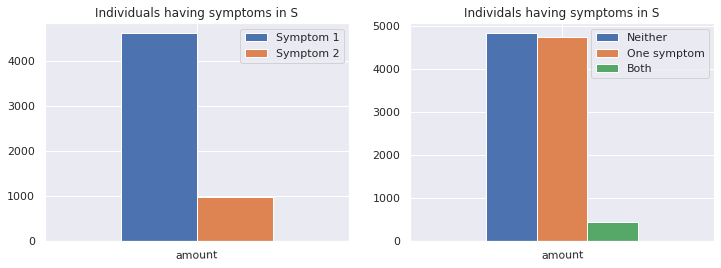

In [6]:
# QUESTION: Have "frequency" as y-label, no x-axis label and keep legend?


s1, = X[["symptom_1"]].to_numpy().T
s2, = X[["symptom_2"]].to_numpy().T
X_symptoms = s1 + s2
none, one, both = [(X_symptoms == i).sum() for i in range(3)]
fig, (ax1, ax2) =  plt.subplots(1, 2, figsize=(12, 4))

pd.DataFrame({"Symptom 1": s1.sum(), "Symptom 2": s2.sum()}, index=["amount"]) \
  .plot.bar(title="Individuals having symptoms in S", rot=1, ax=ax1)
    
pd.DataFrame({"Neither": none, "One symptom": one, "Both": both}, index=["amount"]) \
  .plot.bar(title="Individals having symptoms in S", rot=1, ax=ax2)
None

Notice how symptom 2 is underrepresented in the dataset in addition to the fact that half of the dataset describes individuals with neither symptom 1 or 2. Though we only have two observable symptoms in the dataset, there might be other latent symptoms affecting the individuals as well.

### Visualizing latent structure  

To get some intuition about the structure in the data, we'd like to visualize it.  
Considering our attributes are binary, we have to be picky about which techniques to use.

In [7]:
test_model = PCA(n_components=X.shape[1], random_state=SEED)
test_model.fit(X)
score = np.cumsum(test_model.explained_variance_ratio_)
score[2], score[70]

(0.32643006110799566, 0.8995593171853962)

These numbers show how much of the variance regular PCA would explain. For two dimensions, we would only see 30% of the variance. Likewise, we would need 70 attributes to get 90% of the variance. So we'll go for a different approach.  

We use logisticPCA <a name="ref-1"/>[(Landgraf and Lee, 2020)](#cite-landgraf2020dimensionality)

```LogisticPCA estimates the natural parameters of a Bernoulli distribution in a lower dimensional space. This is done by projecting the natural parameters from the saturated model. A rank-k projection matrix, or equivalently a d x k orthogonal matrix U, is solved for to minimize the Bernoulli deviance.
```  
(From the [documentation](https://cran.r-project.org/web/packages/logisticPCA/README.html) )

We transform the data in the R cells below.

In [8]:
%%R -i X
# Import data X from python scope
library(logisticPCA)
lpca = logisticPCA(X, k=2, quiet=TRUE)
fitted(lpca)
X_lpca = predict(lpca)

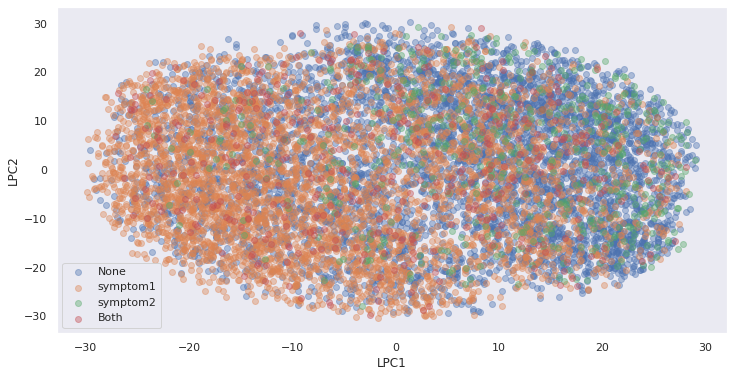

In [9]:
%R -o X_lpca
# export lpca prediction from R scope

x1, x2 = X_lpca.T
plt.subplots(figsize=(12, 6))
conds = [(s1 == j) & (s2 == i) for i in range(2) for j in range(2)]
for cond, label in zip(conds, ["None", "symptom1", "symptom2", "Both"]):
    plt.scatter(x1[cond], x2[cond], label=label, alpha=0.4)
    plt.xlabel("LPC1")
    plt.ylabel("LPC2")
plt.legend()
plt.grid()

If we had a single cause model and we knew that single cause existed in X, the data would certainly be much more separate (even despite our visual limitations). However, we do see some sparsity/separation, primarily between symptom 1 and no symptoms. By looking at the data, we can also see some sparsity diagonally across the plot indicating a k > 1 cluster model.

We test using a 2 cluster model

In [10]:
Xf = features = X.to_numpy()[:, :-2]
clusterer = KMeans(n_clusters=2, random_state=SEED)
k2labels = clusterer.fit_predict(Xf)

centroids = clusterer.cluster_centers_
feat_centroids = np.vstack((features, centroids))

In [11]:
%%R -i feat_centroids
lpca = logisticPCA(feat_centroids, k=2)
fitted(lpca)
feat2d = predict(lpca)

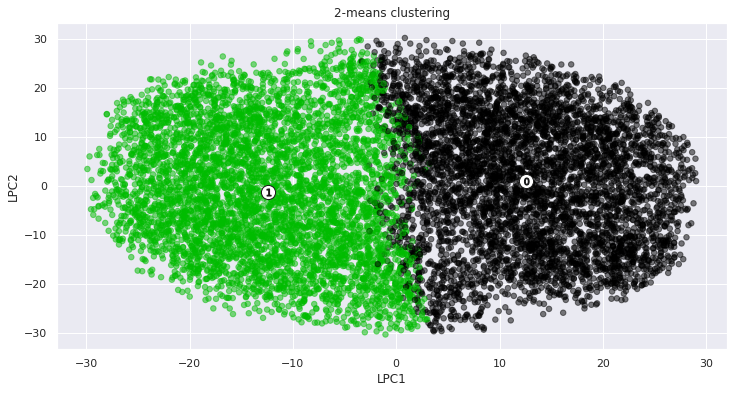

In [12]:
%R -o feat2d
xp = feat2d[:-2]
centroids = feat2d[-2:]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

colors = cm.nipy_spectral(k2labels.astype(float) / 2)

ax.set_title("2-means clustering")


ax.set_xlabel("LPC1")
ax.set_ylabel("LPC2")

ax.scatter(*xp.T, s=30, c=colors, alpha=0.5)
ax.scatter(*centroids.T, marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centroids):
    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

In [13]:
acc_symptoms = np.mean(k2labels == S["symptom_1"].to_numpy())
cluster_score = silhouette_score(X, k2labels)
acc_symptoms, cluster_score

(0.6618, 0.08800879517699431)

With a two-cluster model we get 66% accuracy on symptom 1 which is interesting considering that our mean silhouette score was almost zero (0.08)

So how do the data attributes relate to these symptoms? To find out, we look at the correlation matrix. Pandas built in function uses Pearson correlation coefficient. This works well on continous/numerical data, but is not appropriate for binary datasets, which is what we are using. The metric we decided on is the Jaccard-Needham similarity

In [14]:

def jaccard_similarity(x1, x2):
    return 1 - jaccard(x1, x2)

# this jaccard function returns dissimilarity, so we subtract 1 by it to get the similarity
corr_jc = X.corr(method=jaccard_similarity)
corr_jc

,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
sex,1.000000,0.262565,0.340029,0.344594,0.332142,0.333646,0.327568,0.335952,0.328073,0.327799,...,0.339973,0.331235,0.334356,0.334973,0.323148,0.328303,0.335589,0.360898,0.322988,0.092302
smoker,0.262565,1.000000,0.236687,0.212690,0.228070,0.203707,0.224311,0.229938,0.204194,0.215014,...,0.223488,0.201823,0.210427,0.217023,0.219744,0.218863,0.223744,0.222222,0.196382,0.141137
gen_1,0.340029,0.236687,1.000000,0.319943,0.534234,0.177856,0.372928,0.645867,0.183879,0.281395,...,0.500596,0.185370,0.339915,0.442299,0.398385,0.319324,0.588809,0.312228,0.224162,0.122882
gen_2,0.344594,0.212690,0.319943,1.000000,0.280035,0.383460,0.361213,0.276733,0.238402,0.220811,...,0.317210,0.215456,0.162075,0.260020,0.252080,0.479087,0.314460,0.469134,0.555983,0.111966
gen_3,0.332142,0.228070,0.534234,0.280035,1.000000,0.262958,0.337118,0.469918,0.254154,0.452621,...,0.596697,0.317131,0.442703,0.237838,0.429222,0.393935,0.433154,0.274900,0.258560,0.162580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gen_124,0.328303,0.218863,0.319324,0.479087,0.393935,0.357454,0.302793,0.214692,0.319432,0.316698,...,0.260307,0.255112,0.261346,0.190544,0.349380,1.000000,0.193151,0.380721,0.381000,0.107374
gen_125,0.335589,0.223744,0.588809,0.314460,0.433154,0.149563,0.418272,0.585762,0.192556,0.228519,...,0.546909,0.249405,0.351104,0.461639,0.420204,0.193151,1.000000,0.317800,0.207719,0.110230
gen_126,0.360898,0.222222,0.312228,0.469134,0.274900,0.462094,0.385250,0.331074,0.376045,0.351810,...,0.321857,0.359192,0.307945,0.353833,0.328031,0.380721,0.317800,1.000000,0.432704,0.077365
symptom_1,0.322988,0.196382,0.224162,0.555983,0.258560,0.624087,0.368662,0.269697,0.333054,0.373143,...,0.280867,0.319187,0.218754,0.243330,0.261589,0.381000,0.207719,0.432704,1.000000,0.082043


Using cosine similarity on this data could also be appropriate, so we will do a comparison, including cosine measures

In [15]:
def cosine_similarity(x1, x2):
    return (x1 @ x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

corr_cos = X.corr(method=cosine_similarity)

We select a similarity threshold to get the most important features. This means that we do not include results with values lower than the threshold

<AxesSubplot:title={'center':'using cosine similariy, threshold=0.6'}>

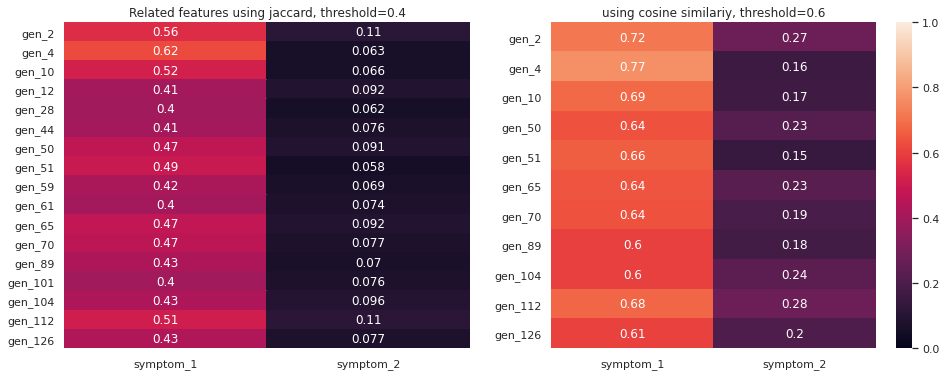

In [16]:
def get_cond(X_corr, threshold): 
    return (X_corr["symptom_1"] > threshold) | (X_corr["symptom_2"] > threshold)

most_corr_jc = corr_jc.loc[get_cond(corr_jc, 0.4)][["symptom_1", "symptom_2"]][:-2]
most_corr_cos = corr_cos.loc[get_cond(corr_cos, 0.6)][["symptom_1", "symptom_2"]][:-2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title(f"Related features using jaccard, threshold={0.4}")
ax2.set_title(f"using cosine similariy, threshold={0.6}")
sns.heatmap(most_corr_jc, annot=True, ax=ax1, vmin=0, vmax=1, cbar=False)
sns.heatmap(most_corr_cos, annot=True, ax=ax2, vmin=0, vmax=1)

The first symptom seems likely to be caused, or at the very least affected by by genetical factors more than anything, both positively and negatively. The second symptom did not give us any highly correlated features, which might indicate that a. there is a nonlinear decision boundary between the features and symptom 3, or b. that there are confounder variables affecting this symptom. Nonetheless, there are multiple attributes in the genetic data with a high similarity, meaning that they probably contribute to symptoms, making this a multi-cause model

In [17]:
X[(X["symptom_1"] == 1) & (X["gen_4"] == 0)].shape, X[(X["symptom_1"] == 1) & (X["gen_2"] == 0)].shape

((945, 130), (1148, 130))

As we can see here, both gen_4 and gen_2 are the two with highest correlation to symptom 1, however there are still instances of symptom 1 being present independent of these attributes


## 1.2 - Focusing on attributes  

***  

Try and determine whether some particular factors are
important for disease epidemiology and may require further investigations.
You need to be able to validate your findings either through a holdout-set methodology,
appropriately used statistical tests, or Bayesian model comparison.

In [94]:
# Pre-processing.
features = np.squeeze(X.iloc[:, :-2].values)
target = np.squeeze(X.iloc[:, -2:].values)

labels = np.zeros_like(target[:, 0])
labels[np.logical_and(target[:, 0] == 0, target[:, 1] == 0)] = 1
labels[np.logical_and(target[:, 0] == 1, target[:, 1] == 0)] = 2
labels[np.logical_and(target[:, 0] == 0, target[:, 1] == 1)] = 3
labels[np.logical_and(target[:, 0] == 1, target[:, 1] == 1)] = 4

### Shap values  

We start by exploring feature importance for predicting symptoms using a `RandomForestClassifier` (RF) cobined with SHAP values <a name="ref-2"/>[(Lundberg et al., 2020)](#cite-lundberg2020local).

In [83]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(features, labels)
explainer = shap.TreeExplainer(clf)

NameError: name 'shap' is not defined

In [30]:
expected_value = explainer.expected_value

In [31]:
samples = features.sample(500)
shap_values = explainer.shap_values(samples)

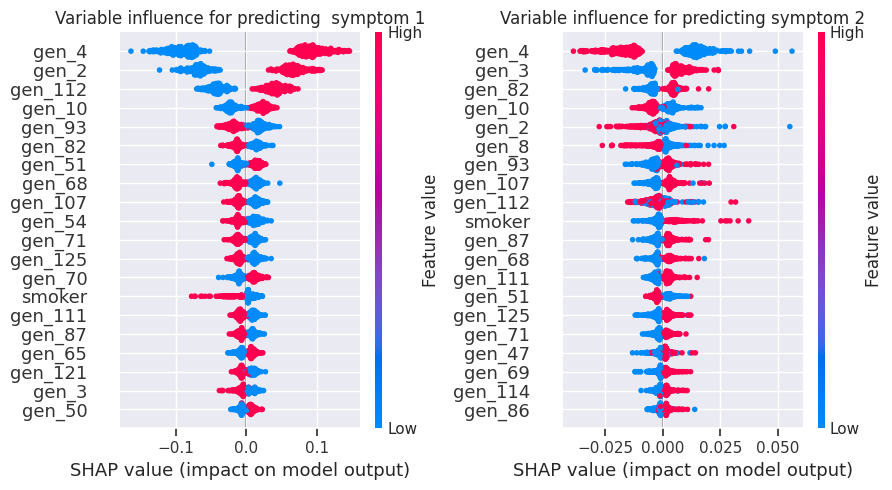

In [32]:
%matplotlib agg

f = plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
plt.title("Variable influence for predicting  symptom 1")
shap.summary_plot(shap_values[1], samples, show=False, plot_size=None)

plt.subplot(1,2,2)
plt.title("Variable influence for predicting symptom 2")
shap.summary_plot(shap_values[2], samples, show=False, plot_size=None)
plt.tight_layout()
f

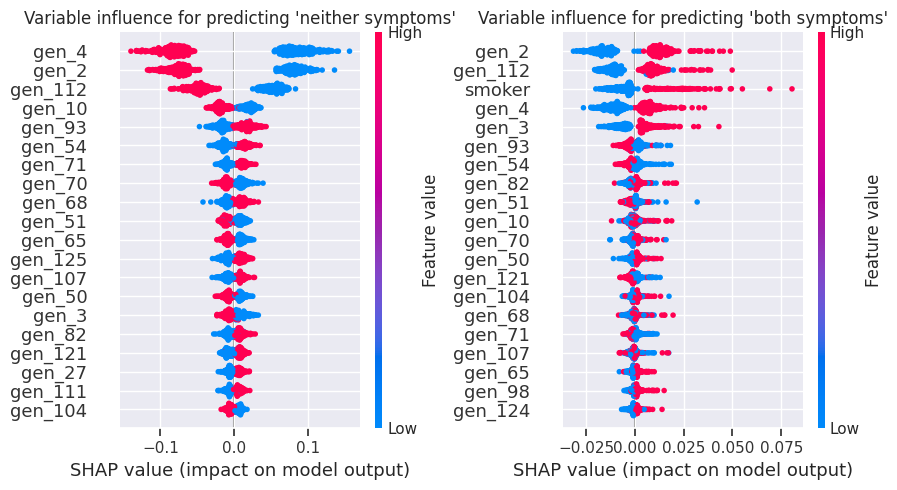

In [33]:
f = plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
plt.title("Variable influence for predicting 'neither symptoms'")
shap.summary_plot(shap_values[0], samples, show=False, plot_size=None)


plt.subplot(1,2,2)
plt.title("Variable influence for predicting 'both symptoms'")
shap.summary_plot(shap_values[3], samples, show=False, plot_size=None)

plt.tight_layout()
f

Our variety of measurements all point towards the same set of attributes having the biggest impact on likelihood of symptoms. I.e. symptom 1 primarily, but also symptom two to some extent. 

To validate our findings using SHAP values, we perform 5-fold CV and estimate the importance of features in each fold. Note that we initally compared the performance of the `RandomForestClassifier` (RF) to a `DecisionTreeClassifier` (Dtree) in predicting symptoms using the `matthews_corrcoef`. An advatange of using RF compared to Dtree in terms of interpretability is that structure of the Dtree can the visualized, revealing the combination of features used during classification. However, the RF clearly outperfomed Dtree, leading us to believe that the RF feature ranking was more appropriate that for Dtree. 

In [ ]:
scores = []
importance = []

kfolds = KFold(5, shuffle=True, random_state=SEED)
for train_idx, test_idx in kfolds.split(X):
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(features[train_idx], labels[train_idx])

    scores.append(matthews_corrcoef(labels[test_idx], clf.predict(features[test_idx])))
    importance.append(clf.feature_importances_)
    
avg_scores, std_scores = np.mean(scores), np.std(scores)
avg_importance, std_importance = np.mean(importance, axis=0), np.std(importance, axis=0)

Here we visualize the top 10 features averaged over 5-fold CV using a RF classifier to predict symptoms.

Text(0, 0.5, 'Feature importance score')

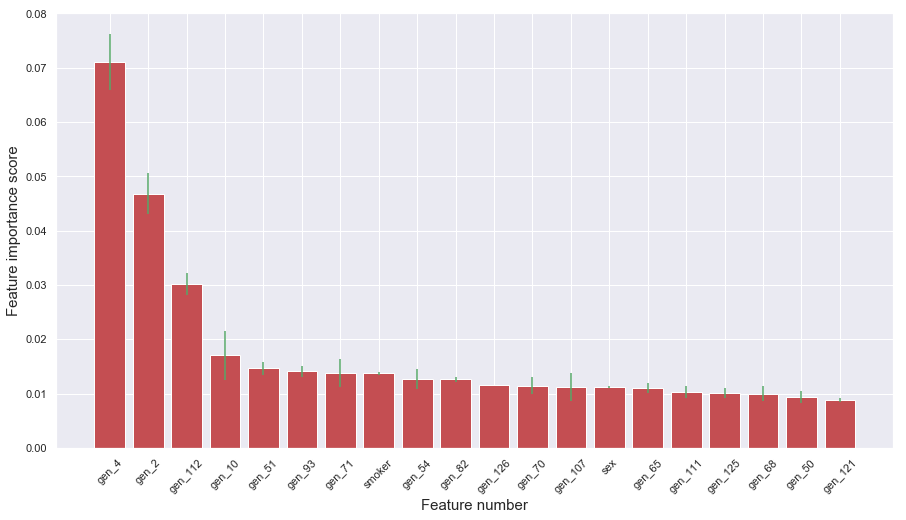

In [89]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(range(20), (avg_importance[np.argsort(avg_importance)[::-1]])[:20],
       color="r", yerr=(std_importance[np.argsort(avg_importance)[::-1]])[:20], ecolor='g')
plt.xticks(range(20), X.columns[np.argsort(avg_importance)[::-1]], rotation=45)
plt.xlabel('Feature number', fontsize=15)
plt.ylabel('Feature importance score', fontsize=15)

From this figure we se an overall correspondance between the ranking of features using SHAP values and the 5-fold CV estimates. We conclude that gen_4, gen_2 and gen_112 are seemingly the 3 most important features for predicting symptoms. However, note that *sex* is considered among the 20 highest ranked features from CV experients contrary to the results derived by SHAP values.

***  

### 1.3 - Measuring the effect of actions

Measuring the effect of actions. We also observe the effects of two different therapeutic
interventions, one of which is placebo, and the other is an experimental drug. Try and measure
the effectiveness of the placebo versus the active treatment. Are there perhaps cases where the
active treatment is never effective, or should it always be recommended?  

***  

In [93]:
# Pre-processing.

A = pd.read_csv(action_path, header=None, sep=" ")
Y = pd.read_csv(outcome_path, header=None, sep=" ")
A = A.rename(index=str, columns={0: 'action'})
Y = Y.rename(index=str, columns={0: 'outcome'})

a = np.squeeze(A.to_numpy())
y = np.squeeze(Y.to_numpy())
x = X.to_numpy()

gender = x[:, 0]
smoker = x[:, 1]
genes = x[:, 2:127]
symp = x[:, 128:]

The following figure illustrates that action $a_1$ has led to more $y_1$ outcomes compared to action $a_0$. However, both actions $a_0$ and $a_1$ has also led to the outcome $y_0$. Moreover, we observe that the distribution of actions and outcomes is heavily skewed towards $a_1$ and $y_1$, respectively.

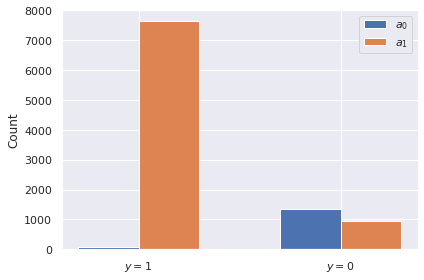

In [36]:
_, axis = plt.subplots(1, 1)

N = 2
ind = np.arange(N)
width = N / 4 - 0.2

rects1 = axis.bar(ind, [sum(y[a == 0]), sum(y[a == 1])], width)
rects2 = axis.bar(ind + width, [sum(y[a == 0] == 0), sum(y[a == 1] == 0)], width)

axis.set_ylabel('Count')
axis.set_xticks(ind + width / 2)
axis.set_xticklabels((r"$y = 1$", r"$y = 0$"))
axis.legend((rects1[0], rects2[0]), ["$a_0$", "$a_1$"])
plt.tight_layout()

## Effect of treatment

Assuming $a_0$ means placebo, $a_1$ is the active treament, $y_1$ is successfull treatment and $y_0$ is un-successfull treatment. To quantify the effectiveness of the placebo $a_0$ versus the active treatment $a_1$ we use the relative risk score $RR$ <a name="ref-3"/>[(Akobeng, 2005)](#cite-akobeng2005understanding) . The Bayesian interpretation of this score, namely

$$
RR = \frac{P(y_1 \mid a_1)}{P(y_1 \mid a_0)}
$$

gives the ratio of successfull treatments $P(y_1 \mid a_1)$ divided by the ratio of placebo responders $P(y_1 \mid a_0)$. If $RR > 1$, then $P(y_1 \mid a_1) > P(y_1 \mid a_0)$ in which case the active treatment $a_1$ lead to more successfull outcomes $y_1$ compared to placebo $a_0$.

In [37]:
def rr_score(a, y) -> float:
    """Compute the relative risk score given actions a and outcomes y."""

    p_y1_given_a0 = sum(y[a == 0] == 1) / sum(a == 0)
    p_y1_given_a1 = sum(y[a == 1] == 1) / sum(a == 1)

    return p_y1_given_a1 / p_y1_given_a0

In [38]:
# Measures the effectiveness of the treatment vs. placebo.
print("RR score male:", rr_score(a[gender == 1], y[gender == 1]))
print("RR score female:", rr_score(a[gender == 0], y[gender == 0]))
print("RR score smoker:", rr_score(a[smoker == 1], y[smoker == 1]))
print("RR score non-smoker:", rr_score(a[smoker == 0], y[smoker == 0]))

RR score male: 53.269982993197274
RR score female: 87.31344028520499
RR score smoker: 103.94162538492436
RR score non-smoker: 58.577538284594574


According to the $RR$ acore and assuming $gender = 1$ indicates male (quite common in epidemiology), treatment appears to be more effective on females and smokers than males and non-smokers. 

Moreover, we can study the impact of $y_1$ on the gender sub-groups conditioned on whether or not they smoke:

In [39]:
male_idx = gender == 1
female_idx = gender == 0

print("RR smoking male:", rr_score(a[male_idx][smoker[male_idx] == 1], 
                                   y[male_idx][smoker[male_idx] == 1]))

print("RR non-smoking male:", rr_score(a[male_idx][smoker[male_idx] == 0], 
                                       y[male_idx][smoker[male_idx] == 0]))

print("RR smoking female:", rr_score(a[female_idx][smoker[female_idx] == 1], 
                                     y[female_idx][smoker[female_idx] == 1]))

print("RR non-smoking female:", rr_score(a[female_idx][smoker[female_idx] == 0], 
                                         y[female_idx][smoker[female_idx] == 0]))

RR smoking male: 86.69682835820896
RR non-smoking male: 46.00143554407121
RR smoking female: 149.89651022864018
RR non-smoking female: 78.9722969338354


According to these $RR$ scores, we observe across gender that smokers are more responsive to treatment than non-smokers. This could mean that smoking impacts/correlates to the underlying condition targeted by the treatment.

In summary it appears that gender could be a usefull co-variate together with smoking in evaluating the outcome of treatment. Recall that in our previous analysis on feature importance for predicintg symptoms, we also found smoking sex amongst the 20 most important features in CV experiments.

From the data we see that a placebo was given if neither symptom 1 nor 2 were present. However, 30 of these about 4800 cases resulted in a measurable effect of the placebo. 

In [40]:
s1, s2 = symp[:, 0], symp[:, 1]

sum(a[np.logical_and(s1 == 0, s2 == 0)]), sum(y[np.logical_and(s1 == 0, s2 == 0)])

(0, 30)

For active treatment we see that symptom 1 was present in 85\% of the cases when active treatment was successfull compared to symptom 2 being present in only about 27\% of these cases. This means that symptom 1 was present three times more often than symptom 2 when active treatment was successfull. However, a symptom was only present in about 12\% of the cases when active treatment failed. 

In [41]:
p_s1_y1 = sum(s1[np.logical_and(a == 1, y == 1)]) / sum(y)
p_s2_y1 = sum(s2[np.logical_and(a == 1, y == 1)]) / sum(y)
rr_s_y1 = p_s1_y1 / p_s2_y1

p_s1_y1, p_s2_y1, rr_s_y1

(0.8508092892329345, 0.2674173117522871, 3.181578947368421)

## Recommending treatment

We can study the benefits and harms of treatment by consulting a decision curve <a name="ref-4"/>[(Vickers, VanCalster and Steyerberg, 2016)](#cite-vickers2016net). This curve shows the net benefit ($nb$), which is constructed from the true positive rate ($TPR$) and false positve rate ($FPR$) according to
$$
    nb = TPR - FPR \left ( \frac{p_t}{1 - p_t} \right ).
$$
Here we assume that the probability of a positive outcome $p(y_1)$ is given by some prediction model. By comparing $p(y_1)$ to some threshold probability $p_t$ we define a positive outcome as $p(y_1) > p_t$. The basic interpretation of a decision curve is that the strategy maximizing $nb$ at a particular $p_t$ probability yields the highest clinical value. 

In [42]:
# Gives proba of y1 given a1.
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x[a == 1], y[a == 1])
pred_probas = clf.predict_proba(x[a == 1])[:, 1]

y_true = y[a == 1]

In [43]:
def net_benefit(y_true, probas, p_t):
    # https://www.bmj.com/content/352/bmj.i6
    
    y_pred = probas >= p_t
    
    tpr = sum(y_pred == y_true) / len(y_true)
    fpr = sum(y_pred != y_true) / len(y_true)
    
    return tpr - fpr * p_t / (1 - p_t)

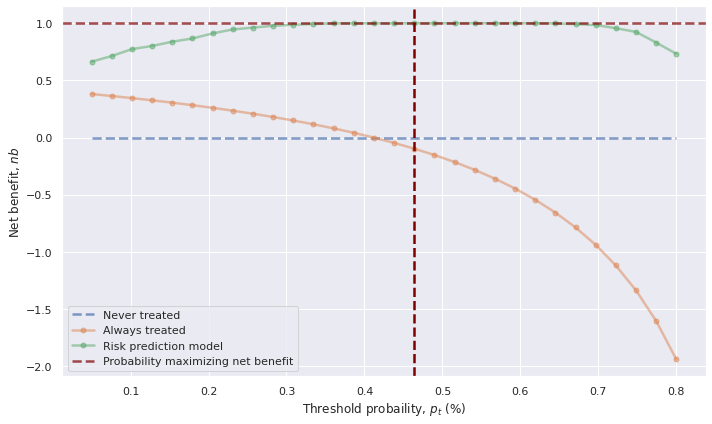

In [44]:
thresholds = np.linspace(0.05, 0.8, 30)
net_benefits = [net_benefit(y_true, pred_probas, p) for p in thresholds]
always_treated = [net_benefit(y_true, 0, p) for p in thresholds]

plt.figure(figsize=(10, 6))
plt.plot([min(thresholds), max(thresholds)], [0, 0], linestyle="--", label="Never treated", 
         alpha=0.7, linewidth=2.5)
plt.plot(thresholds, always_treated, "o-", label="Always treated", markersize=5, 
         alpha=0.5, linewidth=2.5)
plt.plot(thresholds, net_benefits, "o-", label="Risk prediction model", markersize=5, 
         alpha=0.5, linewidth=2.5)
plt.axvline(x=thresholds[np.argmax(net_benefits)], linestyle="--", c="maroon", linewidth=2.5)
plt.axhline(y=np.max(net_benefits), linestyle="--", linewidth=2.5,
            label="Probability maximizing net benefit", c="maroon", alpha=0.7)
plt.ylabel("Net benefit, $nb$")
plt.xlabel(r"Threshold probaility, $p_t$")
plt.legend()
plt.tight_layout()

For this case, the decision curve shows that the prediction model gives higher benefit across all thresholds comapred to always treating individuals. Due to the imbalanced outcomes where $y_1$ outnumbers $y_0$, always treating individuals does not give a higher number of false positives than true positives. Moreover, using a threshold $p_t > 55 \%$ with the RF prediction model to issue treatment leads to a decrease in $nb$ due to fewer true positives. Considering a $p_t$ between $40 - 50 \%$ for $p(y_1)$ given $a_1$ gives the higest $nb$.

## Part 2 - Improved Policy

### 2.1.


We measure the utility of policy $\pi_0$ as the average reward of the observed actions and outcomes 

$$
    \hat{\mathbb{E}}^{\pi_0}(U) = \frac{1}{T} \sum_{t \leq T} U_t.
$$

To provide confidence bounds on $\hat{\mathbb{E}}^{\pi_0}(U)$ we consider the standard deviation

$$
    \hat{\sigma}^{\pi_0} \left ( U \right ) = \left ( \frac{1}{T} \sum_t \left ( U_t - \bar{U} \right )^2 \right )^{1/2}
$$

Here, $\bar{U}$ is the empirical average of the utility $U$. Given data from $\pi_0$ we obtain $\hat{\mathbb{E}}^{\pi_0}(U) = 0.119 \pm 0.352 $. 

Moreover, given some policy $\pi$, we compute the expected utility of this policy as 

$$
    \mathbb{E}^\pi(U, P) = \sum_t y_t P(a_0) + (y_t - 0.1) P(a_1).
$$

where $P$ is the probability of an outcome. Assuming $P$ is normally distributed, we provide confidence bounds on the average probability $\bar{P}$ by 

$$
    \delta_P = \bar{P} \pm t^* \frac{\hat{\sigma}^{\pi} \left ( P \right )}{T}.
$$

Then, we estimate confidence bounds for the expected utility $\mathbb{E}^\pi(U, P) \pm \left [ \mathbb{E}^\pi(U, \bar{P} - \delta_P), \mathbb{E}^\pi(U, \bar{P} + \delta_P) \right ]$.

### 2.2

We design our policy to take actions maximizing the expected reward $\hat{\mathbb{E}}(U)$. Our decision rule is defined as

$$
a_t = \begin{cases}
0 & \text{ if } P(a_0)y_t > (y_t - 0.1)P(a_1)\\ 
1 & \text{ if } P(a_0)y_t \leq (y_t - 0.1)P(a_1)
\end{cases}
$$

This rule requires a model to predict the probability $P(\cdot)$ of each action. We start using logistic regression. In order to optimize for the reward function, we use the negated reward function as loss function when training the classifier. As an alternative we consider a policy with action probablities derived from a neural network and refer to this as the *deep policy*.

* Using the policy based on logistic regression we obtain $\mathbb{E}^\pi(U, P) = 0.128$ with $95$ \% confidence bounds of $[0.1274, 0.1282]$.  
* Using the deep policy trained over 50 epochs based we obtain $\mathbb{E}^\pi(U, P) = 0.141758 \pm 4 \cdot 10^{-6}$.

### Sidenote: policy fairness  

Are there any fairness concerns regarding our policies? Well, how can we define fairness in such a context?
One way is to define them as such:  
Meritocratic fairness: The people who are most vulnerable to a disease should get treated first.  
Group fairness: Irrelevant attributes like gender or ethicity should not impact whether a person is worthy of treatment. Only variables that affect vulnerability factors or disease likelihood. As for this case, we do not know for certain whether gender is a relevant attribute.  

In our dataset we deal with the outcomes 0 and 1 and know nothing further about how an individual is coping with the condition. For the sake of this task, we can make a simplifying assumtion: that people suffer equally/are equally vulnerable for the condition. This means that we only base our treatment decision on one factor: the likelihood of being cured.  
This is the case for our improved and adaptive recommenders.  

For the historical recommender however, we do not know enough about $\pi_0$. It might be the case that the historical policy is unfair. There is a potential danger that this will affect our improved policies as well. 

## Part 3 - Adaptive experiment design

**Note:** we implemented a new version of the TestRecommeder.py script, test_recommender.py for this assignment. The former script contained some mistakes that are corrected in the latter, which will in turn will make the two scripts output different measurements. Outputs in test_recommender.py should be the correct, intentional measurements. test_recommender's benchmark function will run the simulations

As a baseline, we measure against a random treatment policy. We should expect this one to perform the worst.  

In [45]:
data = [i.to_numpy() for i in (X, A, Y)]
random_results = test_recommender.benchmark(recommenders.policies["random"], 5000, 42, *data, verbose=2)

 19%|█▉        | 973/5000 [00:00<00:00, 4858.89it/s]

---- Testing with only two treatments ----
n actions: 2 n_outcomes 2
Fitting historical data to the policy
Fitting treatment outcomes
Running an online test
Testing for  5000 steps


 19%|█▉        | 973/5000 [00:00<00:00, 4809.37it/s]

Total reward: 1083.2999999999745
*** Final analysis of recommender ***
--- Testing with an additional experimental treatment and 126 gene silencing treatments ---
n actions: 129 n_outcomes 2
Fitting historical data to the policy
Fitting treatment outcomes
Running an online test
Testing for  5000 steps


100%|██████████| 5000/5000 [00:00<00:00, 5207.41it/s]

Total reward: -375.70000000002096
*** Final analysis of recommender ***


### Historical Recommender  
The historical recommender class (found in `historical_recommender.py`) uses a logistic regression classifier to approximate the original policy. To find out how well we have approximated $\pi_0$, we measure the classifiers performance on a holdout set. In our case, we do in multple times using k-fold cross valdiation, as we can afford the "computational expense".  

In [46]:
historical_results = test_recommender.benchmark(recommenders.policies["historical"], 5000, 42, *data, verbose=2)

---- Testing with only two treatments ----
n actions: 2 n_outcomes 2
Fitting historical data to the policy


  1%|          | 36/5000 [00:00<00:14, 354.04it/s]

Running an online test
Testing for  5000 steps


100%|██████████| 5000/5000 [00:11<00:00, 426.28it/s]


Total reward: 672.1999999999832
*** Final analysis of recommender ***
Look more into  ['gen_34', 'gen_44', 'gen_85'] as they increase likelihood of treatment
    as well as  ['gen_105', 'gen_98', 'gen_28'] as they decrease likelihood of treatment
The policy had a  0.162 curing rate
--- Testing with an additional experimental treatment and 126 gene silencing treatments ---
n actions: 129 n_outcomes 2
Fitting historical data to the policy


  1%|          | 32/5000 [00:00<00:15, 319.93it/s]

Running an online test
Testing for  5000 steps


100%|██████████| 5000/5000 [00:11<00:00, 433.60it/s]

Total reward: 672.1999999999832
*** Final analysis of recommender ***
Look more into  ['gen_34', 'gen_44', 'gen_85'] as they increase likelihood of treatment
    as well as  ['gen_105', 'gen_98', 'gen_28'] as they decrease likelihood of treatment
The policy had a  0.162 curing rate


In [53]:
clf = LogisticRegression(random_state=0, max_iter=5000)
results = cross_validate(clf, features, A.to_numpy().ravel(), scoring=make_scorer(matthews_corrcoef))
ts = results["test_score"]
print("Mean matthews:", ts.mean(), "Standard deviation", ts.std())

Mean matthews: 0.15327487226421962 Standard deviation 0.012461573017876195


In [62]:
from collections import Counter
Counter(A.to_numpy().ravel())

Counter({1: 2298, 0: 7702})

### Improved Recommender  

Our startegy for improving the recommender policy consists of minimizing the error.  

We propose a new policy: **Min Error Policy**


Let $P_{i, j} = P(x_{i} = 1 \mid y_j)$. We define the policy for selecting an action $a \in \left \{ 0, 1 \right \}$ based on the following decision rule  
$$
a = \arg \max_j P(y_j \mid x).
$$
This rule selects the action maximizing the probability of outcome $y_j \in \left \{ 0, 1 \right \}$ conditioned on the data $x$. Here $x \in \left \{ 0, 1 \right \}^d$ is a binary vector of $d$ features. Since $x_i \in x$ is binary we assume $P(x_i \mid y_j) = P_{i,j}^{x_i} (1 - P_{i,j})^{1 - x_i}$. Moreover, assuming $\forall i=1, \dots, d: x_i$ are independent we have that
$$
    P(x \mid y_j) = \prod_{i=1}^d P(x_i \mid y_j)
$$

To derive a mechanism that executes our decision rule, we consider discriminative functions
$$
g_j(x) = \ln P(x \mid y_j)P(y_j) 
$$
$$
= \sum_{i=1}^d \ln \left \{ p_{i,j}^{x_i} (1 - p_{i,j})^{1 - x_i}\right \} + \ln P(y_j) = \sum_{i=1}^d  x_i \ln \frac{p_{i,j}}{1 - p_{i,j}} + \sum_{i=1}^d \ln (1 - p_{i,j}) + \ln P(y_j) 
$$
and our decision rule follows
$$
a = \begin{cases}
0 & \text{ if } g_0(x) \geq g_1(x) \\ 
1 & \text{ if } g_0(x) < g_1(x)
\end{cases}
$$
Training the classifier entails learning the prior probabilities $P(y_j)$ and the likelihoods $P(x \mid y_j)$.

In [ ]:
improved_results = test_recommender.benchmark(recommenders.policies["improved"], 5000, 42, *data, verbose=2)

### Adaptive Recommender    


The task we are trying to solve is a special case. We first observe a set of historical data, and then try out our recommenders on the patients. The recommender receives data about a patient, selcts a treatment, and receives information about the outcome. Looking at this from a reinforcement learning perspective, we have a set of actions, a vector of observations, and a reward function. But we have no states. Because of that, we cannot model this problem as a markov decision process. This is rather a "contextual multi armed bandit" problem. Contextual, because for each patient, we receive a "context vector". An approximated solution to this problem is LinUCB [CITE](#cite-li2010contextual). In this case, a linear dependency between the expected reward of an action and its context is assumend. I.e. modelling the representation space using a set of linear predictors.

<img src="linUCB.png" alt="Pseudocode for Linear Upper Confidence Bound" style="width: 600px;"/>

In order to get good results, we divide the online action reward loop into an exploration phase, and an exploitation phase.  
The exploration phase is arbitrarily set, and in our case is determined by two given hyperparameters n and k.  
n is the upper limit of the exploration phase and k is the action weight. For isnstance, if k = 10, the number of iterations per action. that way, the number of iterations in the exploration phase is determined as such: $min(k|a|, n)$ where |a| is the cardinality of our global action set. For the second simulation there are 128 possible actions, meaning that there are 1280 iterations in the exploration phase. This should give the model an opportunity to try every action at least 10 times. There is no guarantee however, that it does. In doubt of whether we could use a pre-implemented version, we wrote our own implemetation from the ground up. It is omitted for performance reasons, but is still worth taking a look at in `adaptive_policy.py`  

  2%|▏         | 19/1000 [00:00<00:05, 189.21it/s]

---- Testing with only two treatments ----
n actions: 2 n_outcomes 2
Fitting historical data to the policy
Running an online test
Testing for  1000 steps
STARTING TO EXPLOIT


100%|██████████| 1000/1000 [00:04<00:00, 210.19it/s]


Total reward: 429.19999999999374
*** Final analysis of recommender ***
The adaptive policy had a  0.529 curing rate
--- Testing with an additional experimental treatment and 126 gene silencing treatments ---
n actions: 129 n_outcomes 2
Fitting historical data to the policy


  0%|          | 2/1000 [00:00<00:52, 19.18it/s]

Running an online test
Testing for  1000 steps


100%|██████████| 1000/1000 [01:12<00:00, 13.84it/s]


Total reward: -79.99999999999983
*** Final analysis of recommender ***
The adaptive policy had a  0.02 curing rate


TypeError: no numeric data to plot

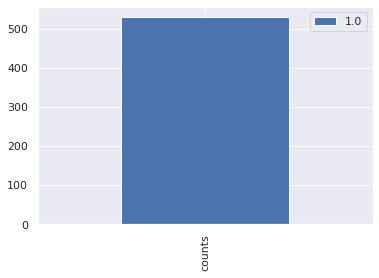

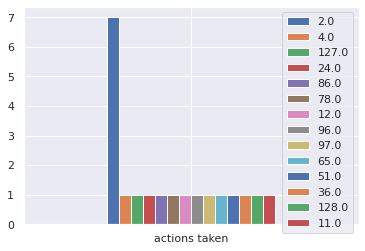

In [66]:
%load_ext autoreload
%autoreload 2
adptive_results = test_recommender.benchmark(recommenders.policies["adaptive"], 1000, 42, *data, verbose=2)

### Performance comparison

In [ ]:
results = {"random": random_results,
           "historical": historical_results,
           "improved": improved_results,
           "adaptive": adptive_results}

df = pd.DataFrame(results, ["Single treatment", "Experimental treatments"])
# df = pd.DataFrame(results)
df.plot.bar(figsize=(10, 7), rot=0, ylabel="Cumulative reward")
None

## Conclusion  

We managed to get an implementation able to try out the new treatments. 

## Feature refinement with best policy

Here we evaluate the effect of feature selection on the selected optimal policy. In all experiments we use a `RandomForestClassifier` to select features ranked by their average importance determined from a 5 fold CV experiment prior to model fitting. Specifically, we consider three approaches where we succesively select the 100, 50 and 20 most important features.

In [ ]:
# TODO: 
# * Run experiments using best (adaptive) recommender using only the top 100, 50 and 20 features. 

## Exploration vs. exploitation

In these experiments we study the adaptive policy over only a few exploration steps compared to several exploration steps.

In [ ]:
# TODO: 
# * Run experiments with few exploration steps and many exploration steps.
# * Compare which action is the most popular in each run.

# References

<a name="cite-landgraf2020dimensionality"/><sup>[^](#ref-1) </sup>Landgraf, Andrew J and Lee, Yoonkyung. 2020. _Dimensionality reduction for binary data through the projection of natural parameters_.

<a name="cite-lundberg2020local"/><sup>[^](#ref-2) </sup>Lundberg, Scott M and Erion, Gabriel and Chen, Hugh and DeGrave, Alex and Prutkin, Jordan M and Nair, Bala and Katz, Ronit and Himmelfarb, Jonathan and Bansal, Nisha and Lee, Su-In. 2020. _From local explanations to global understanding with explainable AI for trees_.

<a name="cite-akobeng2005understanding"/><sup>[^](#ref-3) </sup>Akobeng, AK. 2005. _Understanding measures of treatment effect in clinical trials_.

<a name="cite-vickers2016net"/><sup>[^](#ref-4) </sup>Vickers, Andrew J and Van Calster, Ben and Steyerberg, Ewout W. 2016. _Net benefit approaches to the evaluation of prediction models, molecular markers, and diagnostic tests_.

<a name="cite-li2010contextual"/><sup>[^](#ref-5) </sup>Li, Lihong and Chu, Wei and Langford, John and Schapire, Robert E. 2010. _A contextual-bandit approach to personalized news article recommendation_.



<!--bibtex
@article{landgraf2020dimensionality,
  title={Dimensionality reduction for binary data through the projection of natural parameters},
  author={Landgraf, Andrew J and Lee, Yoonkyung},
  journal={Journal of Multivariate Analysis},
  volume={180},
  pages={104668},
  year={2020},
  publisher={Elsevier}
}

@article{lundberg2020local,
  title={From local explanations to global understanding with explainable AI for trees},
  author={Lundberg, Scott M and Erion, Gabriel and Chen, Hugh and DeGrave, Alex and Prutkin, Jordan M and Nair, Bala and Katz, Ronit and Himmelfarb, Jonathan and Bansal, Nisha and Lee, Su-In},
  journal={Nature machine intelligence},
  volume={2},
  number={1},
  pages={2522--5839},
  year={2020}
}

@article{akobeng2005understanding,
  title={Understanding measures of treatment effect in clinical trials},
  author={Akobeng, AK},
  journal={Archives of disease in childhood},
  volume={90},
  number={1},
  pages={54--56},
  year={2005},
  publisher={BMJ Publishing Group Ltd}
}

@article{vickers2016net,
  title={Net benefit approaches to the evaluation of prediction models, molecular markers, and diagnostic tests},
  author={Vickers, Andrew J and Van Calster, Ben and Steyerberg, Ewout W},
  journal={bmj},
  volume={352},
  pages={i6},
  year={2016},
  publisher={British Medical Journal Publishing Group}
}

@inproceedings{li2010contextual,
  title={A contextual-bandit approach to personalized news article recommendation},
  author={Li, Lihong and Chu, Wei and Langford, John and Schapire, Robert E},
  booktitle={Proceedings of the 19th international conference on World wide web},
  pages={661--670},
  year={2010}
}
--> 